# Lab 08: Airline Tweets Sentiment Analysis

---
author: Jakub Szumny
date: November 8, 2024
embed-resources: true
---

## Introduction

Many times, a person's air-travel experience can be miserable, and so many times this results in these people going to Twitter to complain and seek support from customer service. As a data scientist working for the social team of a major US airline, I am tasked with building a sentiment classifier that will alert customer service representatives to respond to negative tweets, and for positive tweets to automatically be acknowledged. The goal is to develop a model that can accurately classify tweets as negative, neutral, or positive.

## Methods

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

### Data

In [16]:
# load data
tweets = pd.read_csv(
    "https://cs307.org/lab-08/data/tweets.csv",
)

tweets_train, tweets_test = train_test_split(
    tweets,
    test_size=0.25,
    random_state=42,
)

# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

tweets_train, X_train

(      sentiment         airline  \
 2233   positive           Delta   
 10733  negative          United   
 400     neutral      US Airways   
 7615   positive          United   
 4099   negative        American   
 ...         ...             ...   
 5734   negative          United   
 5191    neutral  Virgin America   
 5390   negative          United   
 860     neutral  Virgin America   
 7270   negative          United   
 
                                                     text  
 2233   @JetBlue Then en route to the airport the rebo...  
 10733  @united now you've lost my bags too.  At least...  
 400    @USAirways Hi, can you attach my AA FF# 94LXA6...  
 7615   @United, will you fill it? Yes they will. Than...  
 4099   @AmericanAir thanks! I hope we get movies. Tv'...  
 ...                                                  ...  
 5734   @united Can i get a refund? I would like to bo...  
 5191   @VirginAmerica what is your policy on flying a...  
 5390   @united I'm not su

The airline tweet sentiment data is from the Twitter US Airline Sentiment Data which has been provided for me, which originially comes from Kaggle. The data has been slighlty modified, only to contain the sentiment, text, and the airline variables. The dataset contains one response variable, and two feature variables.

The dataset includes:

## Response
- **sentiment** `[object]`:  
  The sentiment of the tweet. One of `negative`, `neutral`, or `positive`.

## Features
- **text** `[object]`:  
  The full text of the tweet.

## Additional Variables
- **airline** `[object]`:  
  The airline the tweet was “sent” to.

In [12]:
# summary statistics
print("Num Samples:", len(tweets_train))
print("Num Features:", tweets_train.shape[1]-1)

Num Samples: 8235
Num Features: 2


In [13]:
prop = tweets_train.groupby("airline").size()
print("Counts:", prop)
print("Proportions:", (prop/prop.sum()))

Counts: airline
American          1551
Delta             1239
Southwest         1347
US Airways        1664
United            2166
Virgin America     268
dtype: int64
Proportions: airline
American          0.188342
Delta             0.150455
Southwest         0.163570
US Airways        0.202064
United            0.263024
Virgin America    0.032544
dtype: float64


In [14]:
word_counter = CountVectorizer()

words = word_counter.fit_transform(X_train)

cancelled_idx = np.where(word_counter.get_feature_names_out() == "cancelled")
cancelled_count = np.sum(words.todense()[:, cancelled_idx])
print('The Word "cancelled" Appears:', cancelled_count)

please_idx = np.where(word_counter.get_feature_names_out() == "please")
please_count = np.sum(words.todense()[:, please_idx])
print('The Word "please" Appears:', please_count)

thanks_idx = np.where(word_counter.get_feature_names_out() == "thanks")
thanks_count = np.sum(words.todense()[:, thanks_idx])
print('The Word "thanks" Appears:', thanks_count)

The Word "cancelled" Appears: 595
The Word "please" Appears: 325
The Word "thanks" Appears: 587


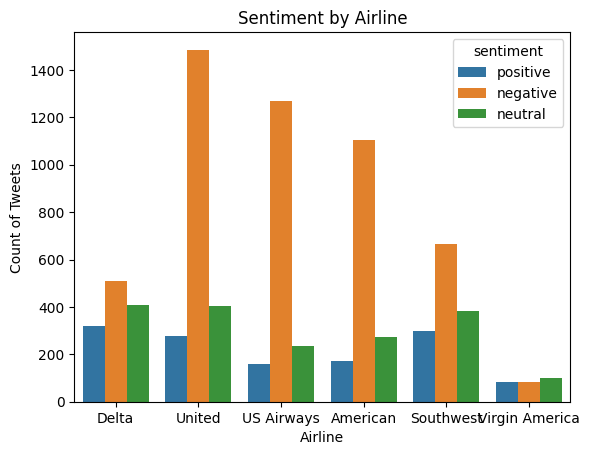

In [15]:
# visualizations
sns.countplot(data=tweets_train, x='airline', hue='sentiment')
plt.title('Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Count of Tweets')
plt.show()



Based off of the summary statistics, we can see that the proportion of tweets per airline is rather evenly split, except for Virgin America, which has the least, meaning they aren't as popular of an airline. Also based off of the word counter statistics, we can see that the word cancelled appeared 595 times, the word please appeared 325 times, and thanks appeared 587. I could assume that the word cancelled is referring to flights being cancelled, which is a negative thing, the word please meaning they are asking for something to be changed also being a negative thing, and thanks being from positive reviews. Just from this alone I can concur with just those keywords what the sentiment could be, which is a good sign for the model. Based off of the visualization, we can see that there tends to be much more negative sentiment towards airlines than positive or neutral ones, and also more neutral than positive, with Virgin America actually being rather split as they have less overall data. I believe that this is because if you have an alright or a good experience, people are less likely to feel a need to go to twitter to tweet about it, whereas if it is a very negative experience, you want to go tell everyone about it. Based on these things, we can make decent assumptions based off of just those 2 variables, but we still need to dive into the actual keywords used in those tweets for the model to be able to actually make accurate predictions on the data.

### Models

In [17]:
# train models
from sklearn.feature_extraction.text import TfidfVectorizer

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", LogisticRegression(max_iter=250)),
    ]
)

# define parameter grid
param_grid = {
    "classifier__C": [2.0, 3.0, 3.5, 4.0],
    'tfidf__max_features': [4000, 4500, 5000],
    'tfidf__ngram_range': [(1, 2), (1,3)],
    'tfidf__min_df': [2, 3, 4],
    }

# # setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", verbose = 2)

# run grid search with cross-validation
grid_search.fit(X_train, y_train)

# print best parameters found and best (cross-validated) score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   0.5s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   0.7s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   0.7s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=2, tfidf__ngram_range=(1, 3); total time=   0.7s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=2, tfidf__ngram_range=(1, 3); total time=   2.1s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=2, tfidf__ngram_range=(1, 3); total time=   0.9s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   1.7s
[CV] END classifier__C=2.0, tfidf__max_features=4000, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   0.7s
[C

Here I used a pipeline and a grid search cross validation to find the best possible parameters for this model, using a Logistic Regression model. I found that the best C was 2.0, the best tfidf max features was 4500, the best tfidf min df was 3, and that the best tfidf ngram range was (1, 2) to get the best results. From this I revieved a cross validation accuracy of .784, which is solid but definitely not perfect.

## Results

In [18]:
# report model metrics
y_pred = grid_search.best_estimator_.predict(X_test)
test_accruacy = (y_pred == y_test).mean()
print(test_accruacy)

0.7959927140255009


Here we can see that on the test set, the model had an accuracy of .796, on data it has never seen before, which is definitely good, but not amazing.

In [19]:
from joblib import dump
dump(grid_search, "airline-sentiment.joblib")

['airline-sentiment.joblib']

## Discussion

After receiving a test set accuracy of .796, I can say that this model definitely is solid, but also could be improved further to receieve a higher accuracy score. It could be used for real life responses to tweets, as they are not life-threatening or anything, but if you could some false positives, and replied a thank you to a negative comment about your airline, it would be a very bad look for the airline, so it should be refined before being put to use.

Again, some potential mistakes the model could make are replying automatic responses to negative comments, which are only meant for postive comments. A false negative wouldn't be as bad, as simply the comment would be alert the airline, and they could read and see that it is actually a positive comment. If on the other hand, a negative comment receives an automatic reply instead of alerting the airline, it could have some serious consequences. Assuming that the automatic response is similar to "Thank you for the kind words" or in that realm of a reply, then it would show a very bad look for the company. It would seem to users of twitter that the company doesn't care for their customers, and doesn't even take the time to review negative comments, and instead just send automatic replies. This could result in severe backlash, and a decline in usage of that airline.



### Conclusion

To conclude, given the high but not perfect accuracy of .796, I would not yet recommend this model for usage in the real world. It definitely is a solid mode, but there is still too much risk of false postive messages, that could result in some serious backlash. Obviously this is not a life or death type scenario, but it could definitely negatively impact the airline's business, if a negative tweet was disregarded. I believe this model could definitely still be improved, possibly by refining the text processing, or using a better model for the predictions. If the text processing was more refined, the model might possibly be able to make better predictions from tweets, but always there are some things AI can not pick up on from human tweets, possibly even sarcasm.